The following script read downloaded NLDAS outputs from 3 different models and compare the temporal and spatial QSb 

In [4]:
# ----- Setup -----
import os
from pathlib import Path
import xarray as xr

import dask
from dask.diagnostics import ProgressBar
import geopandas as gpd

# Inputs

In [48]:
# ----- Inputs -----
# Your root folder (Windows)
ROOT = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016")

# Sanity checks
print("Root exists? ->", ROOT.exists())
if not ROOT.exists():
    raise FileNotFoundError(f"Check the path: {ROOT}")

# ----- Layers -----
countries = gpd.read_file(r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_cultural/ne_10m_admin_0_countries_lakes.shp")
MI_LINES  = Path(r"S:/Data/GIS_Data/Derived/MI_Model/Watersheds/MI_Model_HUC6.shp")
HUC2 =Path(r"S:\Data\GIS_Data\Downloaded\Great_Lakes\Basins\HUC2basin.shp")
HUC4 =Path(r"S:\Data\GIS_Data\Downloaded\WatershedBoundaryDataset\HUC_4\HU04.shp")
GL_SUBBASIN  = Path(r"S:\Data\GIS_Data\Downloaded\Great_Lakes\Basins\glbasins_gen.shp")

Root exists? -> True


# Output

In [11]:
# output folder
Figures = Path(r"D:\Users\abolmaal\modelling\Projects\GreatLakes\Figures")
OUTDIR = Path(r"D:\Users\abolmaal\modelling\Projects\GreatLakes\outputs")

In [1]:
import netCDF4
import xarray as xr
from netCDF4 import Dataset





In [7]:

ds = xr.open_dataset(os.path.join(ROOT, "NLDAS_MOS0125_M.A201601.020.nc"))  # type: xarray.DataSet
ds  

<xarray.Dataset> Size: 16MB
Dimensions:          (time: 1, bnds: 2, lat: 224, lon: 464)
Coordinates:
  * time             (time) datetime64[ns] 8B 2016-01-01
  * lat              (lat) float32 896B 25.06 25.19 25.31 ... 52.69 52.81 52.94
  * lon              (lon) float32 2kB -124.9 -124.8 -124.7 ... -67.19 -67.06
Dimensions without coordinates: bnds
Data variables: (12/39)
    time_bnds        (time, bnds) datetime64[ns] 16B ...
    SWdown           (time, lat, lon) float32 416kB ...
    LWdown           (time, lat, lon) float32 416kB ...
    SWnet            (time, lat, lon) float32 416kB ...
    LWnet            (time, lat, lon) float32 416kB ...
    Qle              (time, lat, lon) float32 416kB ...
    ...               ...
    CanopInt         (time, lat, lon) float32 416kB ...
    ACond            (time, lat, lon) float32 416kB ...
    CCond            (time, lat, lon) float32 416kB ...
    LAI              (time, lat, lon) float32 416kB ...
    GVEG             (time, lat, lon) float32 416kB ...
    Streamflow       (time, lat, lon) float32 416kB ...
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        monthly
    shortname:              NLDAS_MOS0125_M_2.0
    title:                  NLDAS Mosaic Land Surface Model L4 Monthly 0.125 ...
    version:                2.0
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/ ; https://lis.g...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  25.0625
    SOUTH_WEST_CORNER_LON:  -124.9375
    DX:                     0.125
    DY:                     0.125

# Plot the Runoff data for year 2016 over Michigan

[INFO] 'Qsb' found in group: /


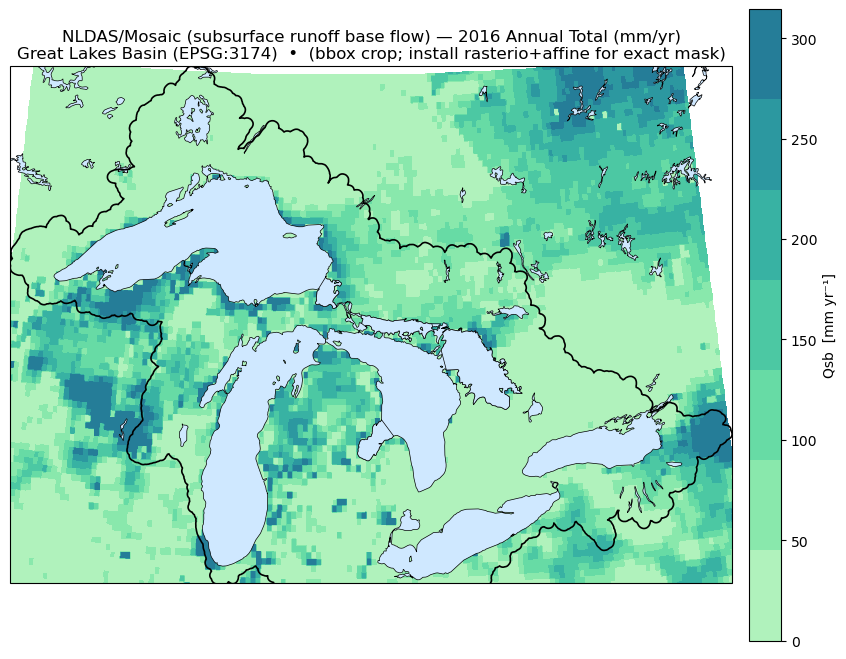

In [4]:
# ==== NLDAS/Mosaic Qs — 2016 Annual Total (mm/yr),
#      clipped to GL boundary, smooth plot in EPSG:3174
#      with lakes overlay ====
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps 
# -------------------- Paths & constants --------------------
ROOT_2016   = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016")
VAR         = "Qsb"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT  = 4326
CRS_PLOT    = 3174  # Great Lakes Albers

# -------------------- Find which group contains the variable --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root
        return walk(nc, "")

# -------------------- Collect & open all 2016 files --------------------
files = sorted(str(p) for p in ROOT_2016.rglob("*.nc*"))
if not files:
    raise FileNotFoundError(f"No .nc/.nc4 files found under {ROOT_2016}")

group_path = find_group_with_var(files[0], VAR)
if group_path is None:
    raise KeyError(f"Variable '{VAR}' not found in {files[0]} (root or any subgroup).")
print(f"[INFO] '{VAR}' found in group: {group_path or '/'}")

open_kwargs = dict(
    combine="by_coords",
    chunks={"time": 12},
    parallel=False,
    decode_times=True,
    engine="netcdf4",
    backend_kwargs={"autoclose": True},
)
ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)
if VAR not in ds:
    raise KeyError(f"{VAR!r} not in dataset. Available: {list(ds.data_vars)[:20]}")

# -------------------- Annual total (mm/yr) --------------------
# Monthly totals: kg/m^2 == mm/month → sum across months
da = ds[VAR].sum("time", skipna=True)
da.attrs["units"] = "mm yr-1"
da.attrs["long_name"] = "Subsurface runoff base flow (Qsb) annual total"

# -------------------- Tidy coords (lon/lat ascending; lon in [-180,180]) --------------------
lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
if not (lon_name and lat_name):
    raise KeyError("Couldn't find lon/lat coords.")

lon_fix = xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])
da = da.assign_coords({lon_name: lon_fix})
if not np.all(np.diff(da[lon_name].values) > 0):
    da = da.sortby(lon_name)
if not np.all(np.diff(da[lat_name].values) > 0):
    da = da.sortby(lat_name)

lon_vals = da[lon_name].values
lat_vals = da[lat_name].values

# -------------------- Clip to GL boundary (mask on lon/lat grid) --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

masked = da
used_bbox_only = False
try:
    from rasterio.features import rasterize
    from affine import Affine
    dlon = float(lon_vals[1] - lon_vals[0])
    dlat = float(lat_vals[1] - lat_vals[0])
    transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                       float(lat_vals.min()) - dlat/2)
                    * Affine.scale(dlon, dlat))
    shapes = [(glb_poly.__geo_interface__, 1)]
    mask = rasterize(shapes, out_shape=(lat_vals.size, lon_vals.size),
                     transform=transform_ll, fill=0).astype(bool)
    masked = da.where(xr.DataArray(mask, dims=(lat_name, lon_name)), np.nan)
except Exception:
    used_bbox_only = True
    xmin, ymin, xmax, ymax = glb_ll.total_bounds
    masked = da.sel({lon_name: slice(xmin, xmax), lat_name: slice(ymin, ymax)})

# -------------------- Prep arrays for smooth plotting --------------------
da_plot = masked.transpose(lat_name, lon_name)  # (lat, lon)
Z = np.asarray(da_plot)

lat_for_extent = da_plot[lat_name].values
lon_for_extent = da_plot[lon_name].values

# Ensure imshow origin='lower' matches increasing lat/lon
if not np.all(np.diff(lat_for_extent) > 0):
    Z = Z[::-1, :]
    lat_for_extent = np.sort(lat_for_extent)
if not np.all(np.diff(lon_for_extent) > 0):
    Z = Z[:, ::-1]
    lon_for_extent = np.sort(lon_for_extent)

extent_lonlat = [float(lon_for_extent.min()), float(lon_for_extent.max()),
                 float(lat_for_extent.min()), float(lat_for_extent.max())]

# Robust color limits
finite = np.isfinite(Z)
vmin = np.nanpercentile(Z[finite], 2) if np.any(finite) else None
vmax = np.nanpercentile(Z[finite], 98) if np.any(finite) else None
if vmin is not None and vmax is not None and vmin >= vmax:
    vmin = vmax = None

# -------------------- Read + project lakes --------------------
lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

# -------------------- Plot (smooth, EPSG:3174) with GL extent + lakes --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=proj)

# Smooth raster (bilinear resampling lon/lat → EPSG:3174)
im = ax.imshow(
    Z,
    extent=extent_lonlat,
    transform=pc,             # data CRS
    origin="lower",
    interpolation="bilinear", # smoothing
    cmap=cmaps.tealgrn,
    vmin=vmin, vmax=vmax,
    zorder=1,
)

# Lakes (light blue fill, black edge)
lakes_proj.plot(
    ax=ax,
    facecolor="#cfe8ff",      # light blue fill
    edgecolor="black",        # black outline
    linewidth=0.5,
    zorder=2,
)

# GL boundary overlay
glb_proj = glb_ll.to_crs(CRS_PLOT)
glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

# Extent EXACTLY = GL_BOUNDARY extent in EPSG:3174
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps
ax.set_extent([minx, maxx, miny, maxy], crs=proj)

# Colorbar & title
cb = plt.colorbar(im, ax=ax, shrink=0.82, pad=0.02)
cb.set_label("Qsb  [mm yr⁻¹]")

title = "NLDAS/Mosaic (subsurface runoff base flow) — 2016 Annual Total (mm/yr)\nGreat Lakes Basin (EPSG:3174)"
if used_bbox_only:
    title += "  •  (bbox crop; install rasterio+affine for exact mask)"
ax.set_title(title)
plt.savefig(Figures / "nldas_mosaic_qsb_2016_glb.png", dpi=300)
plt.tight_layout()
plt.show()



[INFO] 'Qsb' found in group: /


NameError: name 'Figures' is not defined

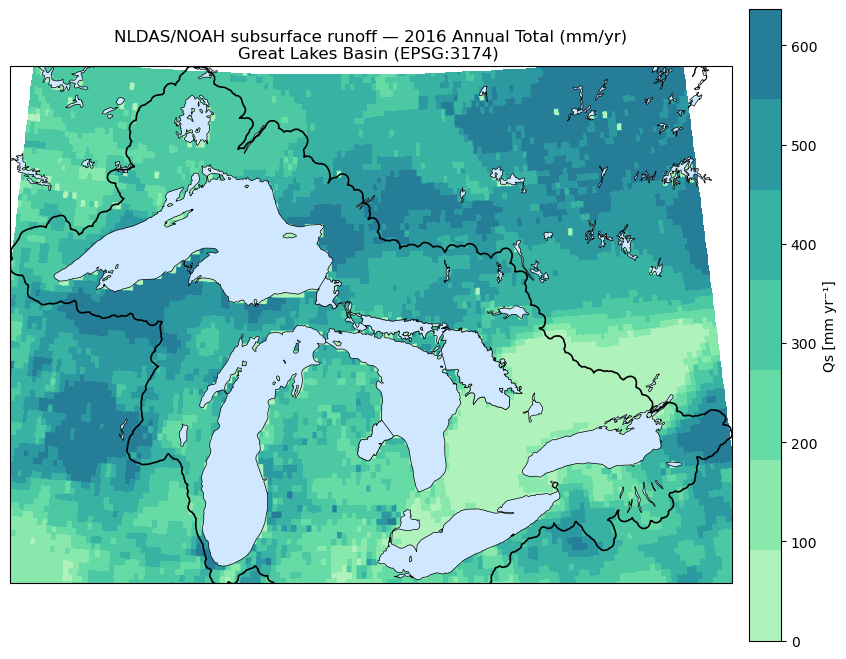

In [2]:
# ==== NLDAS/Mosaic Qs — 2016 Annual Total (mm/yr),
#      clipped to GL boundary, smooth plot in EPSG:3174
#      with lakes overlay ====
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps 
# -------------------- Paths & constants --------------------
ROOT_2016   = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Noah\NLDAS\NLDAS_NOAH0125_M.2.0\2016")
VAR         = "Qsb"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT  = 4326
CRS_PLOT    = 3174  # Great Lakes Albers

# -------------------- Find which group contains the variable --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root
        return walk(nc, "")

# -------------------- Collect & open all 2016 files --------------------
files = sorted(str(p) for p in ROOT_2016.rglob("*.nc*"))
if not files:
    raise FileNotFoundError(f"No .nc/.nc4 files found under {ROOT_2016}")

group_path = find_group_with_var(files[0], VAR)
if group_path is None:
    raise KeyError(f"Variable '{VAR}' not found in {files[0]} (root or any subgroup).")
print(f"[INFO] '{VAR}' found in group: {group_path or '/'}")

open_kwargs = dict(
    combine="by_coords",
    chunks={"time": 12},
    parallel=False,
    decode_times=True,
    engine="netcdf4",
    backend_kwargs={"autoclose": True},
)
ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)
if VAR not in ds:
    raise KeyError(f"{VAR!r} not in dataset. Available: {list(ds.data_vars)[:20]}")

# -------------------- Annual total (mm/yr) --------------------
# Monthly totals: kg/m^2 == mm/month → sum across months
da = ds[VAR].sum("time", skipna=True)
da.attrs["units"] = "mm yr-1"
da.attrs["long_name"] = "Subsurface runoff (Qs) annual total"

# -------------------- Tidy coords (lon/lat ascending; lon in [-180,180]) --------------------
lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
if not (lon_name and lat_name):
    raise KeyError("Couldn't find lon/lat coords.")

lon_fix = xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])
da = da.assign_coords({lon_name: lon_fix})
if not np.all(np.diff(da[lon_name].values) > 0):
    da = da.sortby(lon_name)
if not np.all(np.diff(da[lat_name].values) > 0):
    da = da.sortby(lat_name)

lon_vals = da[lon_name].values
lat_vals = da[lat_name].values

# -------------------- Clip to GL boundary (mask on lon/lat grid) --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

masked = da
used_bbox_only = False
try:
    from rasterio.features import rasterize
    from affine import Affine
    dlon = float(lon_vals[1] - lon_vals[0])
    dlat = float(lat_vals[1] - lat_vals[0])
    transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                       float(lat_vals.min()) - dlat/2)
                    * Affine.scale(dlon, dlat))
    shapes = [(glb_poly.__geo_interface__, 1)]
    mask = rasterize(shapes, out_shape=(lat_vals.size, lon_vals.size),
                     transform=transform_ll, fill=0).astype(bool)
    masked = da.where(xr.DataArray(mask, dims=(lat_name, lon_name)), np.nan)
except Exception:
    used_bbox_only = True
    xmin, ymin, xmax, ymax = glb_ll.total_bounds
    masked = da.sel({lon_name: slice(xmin, xmax), lat_name: slice(ymin, ymax)})

# -------------------- Prep arrays for smooth plotting --------------------
da_plot = masked.transpose(lat_name, lon_name)  # (lat, lon)
Z = np.asarray(da_plot)

lat_for_extent = da_plot[lat_name].values
lon_for_extent = da_plot[lon_name].values

# Ensure imshow origin='lower' matches increasing lat/lon
if not np.all(np.diff(lat_for_extent) > 0):
    Z = Z[::-1, :]
    lat_for_extent = np.sort(lat_for_extent)
if not np.all(np.diff(lon_for_extent) > 0):
    Z = Z[:, ::-1]
    lon_for_extent = np.sort(lon_for_extent)

extent_lonlat = [float(lon_for_extent.min()), float(lon_for_extent.max()),
                 float(lat_for_extent.min()), float(lat_for_extent.max())]

# Robust color limits
finite = np.isfinite(Z)
vmin = np.nanpercentile(Z[finite], 2) if np.any(finite) else None
vmax = np.nanpercentile(Z[finite], 98) if np.any(finite) else None
if vmin is not None and vmax is not None and vmin >= vmax:
    vmin = vmax = None

# -------------------- Read + project lakes --------------------
lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

# -------------------- Plot (smooth, EPSG:3174) with GL extent + lakes --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=proj)

# Smooth raster (bilinear resampling lon/lat → EPSG:3174)
im = ax.imshow(
    Z,
    extent=extent_lonlat,
    transform=pc,             # data CRS
    origin="lower",
    interpolation="bilinear", # smoothing
    cmap=cmaps.tealgrn,
    vmin=vmin, vmax=vmax,
    zorder=1,
)

# Lakes (light blue fill, black edge)
lakes_proj.plot(
    ax=ax,
    facecolor="#cfe8ff",      # light blue fill
    edgecolor="black",        # black outline
    linewidth=0.5,
    zorder=2,
)

# GL boundary overlay
glb_proj = glb_ll.to_crs(CRS_PLOT)
glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

# Extent EXACTLY = GL_BOUNDARY extent in EPSG:3174
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps
ax.set_extent([minx, maxx, miny, maxy], crs=proj)

# Colorbar & title
cb = plt.colorbar(im, ax=ax, shrink=0.82, pad=0.02)
cb.set_label("Qs [mm yr⁻¹]")

title = "NLDAS/NOAH subsurface runoff — 2016 Annual Total (mm/yr)\nGreat Lakes Basin (EPSG:3174)"
if used_bbox_only:
    title += " "
ax.set_title(title)

plt.tight_layout()
plt.savefig(Figures / "nldas_noah_qs_2016_glb.png", dpi=300)
plt.show()


[INFO] 'Qs' found in group: /


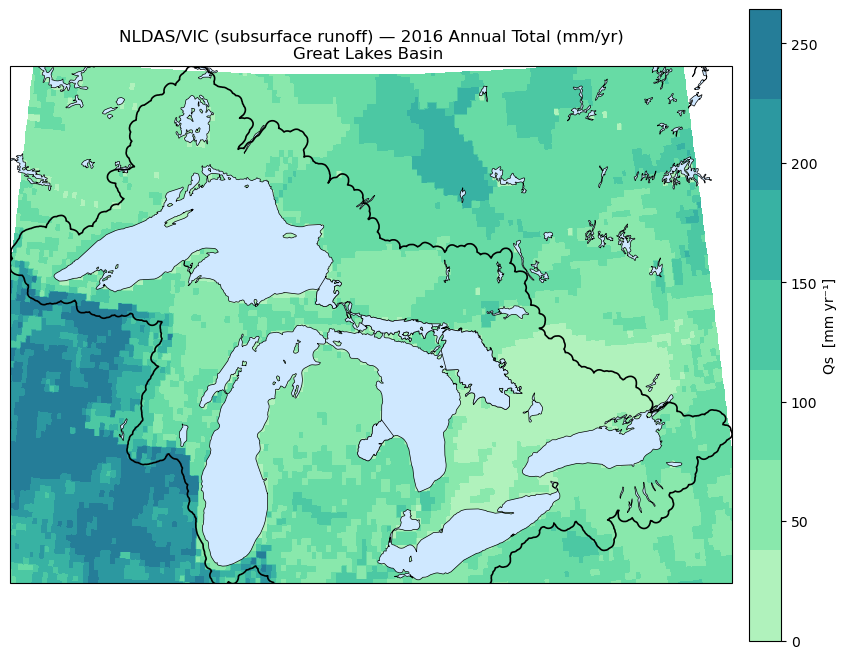

In [ ]:
# ==== NLDAS/Mosaic Qs — 2016 Annual Total (mm/yr),
#      clipped to GL boundary, smooth plot in EPSG:3174
#      with lakes overlay ====
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps 
# -------------------- Paths & constants --------------------
ROOT_2016   = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\VIC\NLDAS\NLDAS_VIC0125_M.2.0\2016")
VAR         = "Qsb"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT  = 4326
CRS_PLOT    = 3174  # Great Lakes Albers

# -------------------- Find which group contains the variable --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root
        return walk(nc, "")

# -------------------- Collect & open all 2016 files --------------------
files = sorted(str(p) for p in ROOT_2016.rglob("*.nc*"))
if not files:
    raise FileNotFoundError(f"No .nc/.nc4 files found under {ROOT_2016}")

group_path = find_group_with_var(files[0], VAR)
if group_path is None:
    raise KeyError(f"Variable '{VAR}' not found in {files[0]} (root or any subgroup).")
print(f"[INFO] '{VAR}' found in group: {group_path or '/'}")

open_kwargs = dict(
    combine="by_coords",
    chunks={"time": 12},
    parallel=False,
    decode_times=True,
    engine="netcdf4",
    backend_kwargs={"autoclose": True},
)
ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)
if VAR not in ds:
    raise KeyError(f"{VAR!r} not in dataset. Available: {list(ds.data_vars)[:20]}")

# -------------------- Annual total (mm/yr) --------------------
# Monthly totals: kg/m^2 == mm/month → sum across months
da = ds[VAR].sum("time", skipna=True)
da.attrs["units"] = "mm yr-1"
da.attrs["long_name"] = "Subsurface runoff (Qs) annual total"

# -------------------- Tidy coords (lon/lat ascending; lon in [-180,180]) --------------------
lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
if not (lon_name and lat_name):
    raise KeyError("Couldn't find lon/lat coords.")

lon_fix = xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])
da = da.assign_coords({lon_name: lon_fix})
if not np.all(np.diff(da[lon_name].values) > 0):
    da = da.sortby(lon_name)
if not np.all(np.diff(da[lat_name].values) > 0):
    da = da.sortby(lat_name)

lon_vals = da[lon_name].values
lat_vals = da[lat_name].values

# -------------------- Clip to GL boundary (mask on lon/lat grid) --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

masked = da
used_bbox_only = False
try:
    from rasterio.features import rasterize
    from affine import Affine
    dlon = float(lon_vals[1] - lon_vals[0])
    dlat = float(lat_vals[1] - lat_vals[0])
    transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                       float(lat_vals.min()) - dlat/2)
                    * Affine.scale(dlon, dlat))
    shapes = [(glb_poly.__geo_interface__, 1)]
    mask = rasterize(shapes, out_shape=(lat_vals.size, lon_vals.size),
                     transform=transform_ll, fill=0).astype(bool)
    masked = da.where(xr.DataArray(mask, dims=(lat_name, lon_name)), np.nan)
except Exception:
    used_bbox_only = True
    xmin, ymin, xmax, ymax = glb_ll.total_bounds
    masked = da.sel({lon_name: slice(xmin, xmax), lat_name: slice(ymin, ymax)})

# -------------------- Prep arrays for smooth plotting --------------------
da_plot = masked.transpose(lat_name, lon_name)  # (lat, lon)
Z = np.asarray(da_plot)

lat_for_extent = da_plot[lat_name].values
lon_for_extent = da_plot[lon_name].values

# Ensure imshow origin='lower' matches increasing lat/lon
if not np.all(np.diff(lat_for_extent) > 0):
    Z = Z[::-1, :]
    lat_for_extent = np.sort(lat_for_extent)
if not np.all(np.diff(lon_for_extent) > 0):
    Z = Z[:, ::-1]
    lon_for_extent = np.sort(lon_for_extent)

extent_lonlat = [float(lon_for_extent.min()), float(lon_for_extent.max()),
                 float(lat_for_extent.min()), float(lat_for_extent.max())]

# Robust color limits
finite = np.isfinite(Z)
vmin = np.nanpercentile(Z[finite], 2) if np.any(finite) else None
vmax = np.nanpercentile(Z[finite], 98) if np.any(finite) else None
if vmin is not None and vmax is not None and vmin >= vmax:
    vmin = vmax = None

# -------------------- Read + project lakes --------------------
lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

# -------------------- Plot (smooth, EPSG:3174) with GL extent + lakes --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=proj)

# Smooth raster (bilinear resampling lon/lat → EPSG:3174)
im = ax.imshow(
    Z,
    extent=extent_lonlat,
    transform=pc,             # data CRS
    origin="lower",
    interpolation="bilinear", # smoothing
    cmap=cmaps.tealgrn,
    vmin=vmin, vmax=vmax,
    zorder=1,
)

# Lakes (light blue fill, black edge)
lakes_proj.plot(
    ax=ax,
    facecolor="#cfe8ff",      # light blue fill
    edgecolor="black",        # black outline
    linewidth=0.5,
    zorder=2,
)

# GL boundary overlay
glb_proj = glb_ll.to_crs(CRS_PLOT)
glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

# Extent EXACTLY = GL_BOUNDARY extent in EPSG:3174
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps
ax.set_extent([minx, maxx, miny, maxy], crs=proj)

# Colorbar & title
cb = plt.colorbar(im, ax=ax, shrink=0.82, pad=0.02)
cb.set_label("Qs  [mm yr⁻¹]")

title = "NLDAS/VIC (subsurface runoff) — 2016 Annual Total (mm/yr)\nGreat Lakes Basin"
if used_bbox_only:
    title += " "
ax.set_title(title)
plt.savefig(Figures /"nldas_vic_qs_2016_glb.png", dpi=300)
plt.tight_layout()
plt.show()

# comparison 

[INFO] 'Qsb' found in group: / for MOSAIC
[INFO] 'Qsb' found in group: / for NOAH
[INFO] 'Qsb' found in group: / for VIC


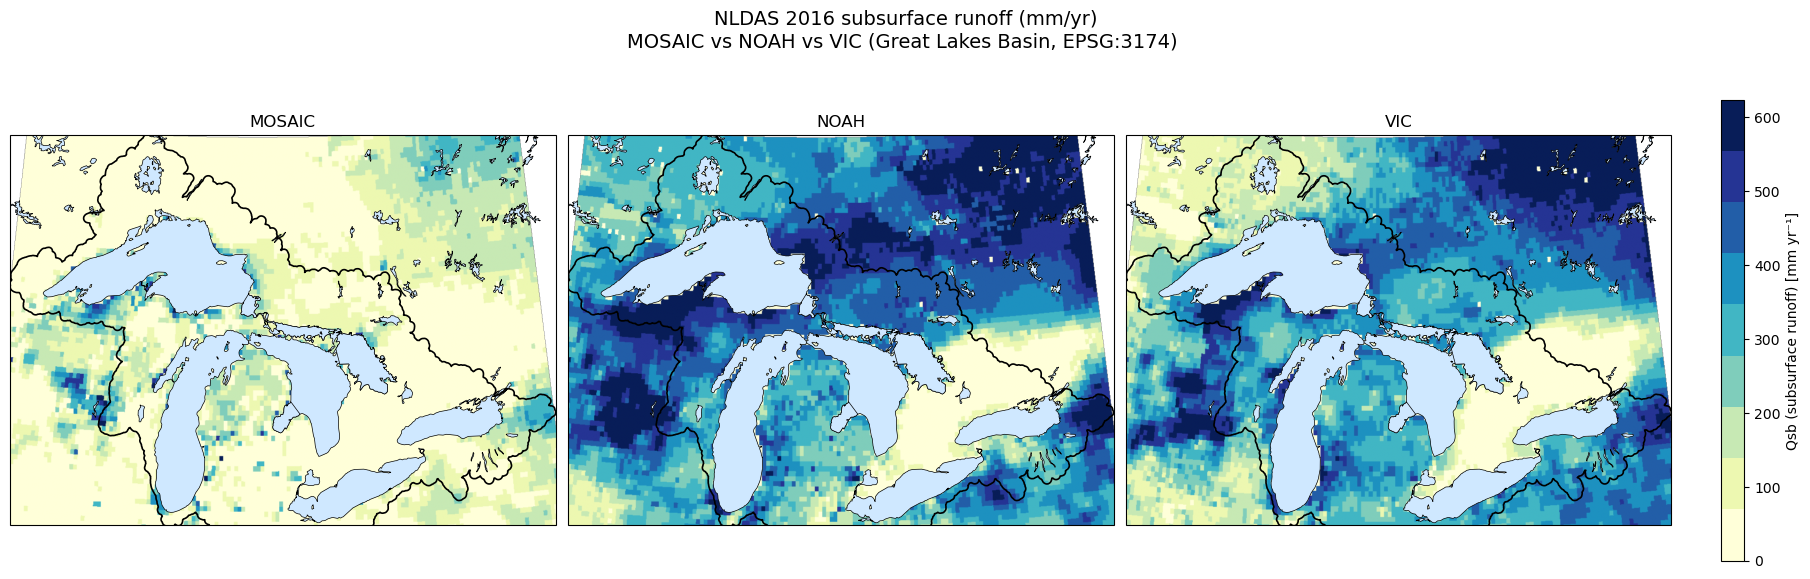

In [11]:
# ==== NLDAS/Mosaic, NOAH, VIC Qs — 2016 Annual Total (mm/yr),
#      clipped to GL boundary, smooth tripanel comparison in EPSG:3174 ====

from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps 
# -------------------- Paths & constants --------------------
VAR = "Qsb"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)

MODEL_ROOTS = {
    "MOSAIC": Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016"),
    "NOAH":   Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Noah\NLDAS\NLDAS_NOAH0125_M.2.0\2016"),
    "VIC":    Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\VIC\NLDAS\NLDAS_VIC0125_M.2.0\2016"),
}

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT = 4326
CRS_PLOT   = 3174  # Great Lakes Albers

# -------------------- Helper: find group containing VAR --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root group
        return walk(nc, "")

# -------------------- Read GL boundary and lakes --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

glb_proj = glb_ll.to_crs(CRS_PLOT)
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps

# -------------------- Process models --------------------
masked_arrays = {}   # model_name -> 2D numpy array (lat x lon)
lon_vals = None
lat_vals = None
lon_name = None
lat_name = None
mask_arr = None
used_bbox_only = False

for model_name, root in MODEL_ROOTS.items():
    files = sorted(str(p) for p in root.rglob("*.nc*"))
    if not files:
        raise FileNotFoundError(f"No .nc/.nc4 files found under {root} for {model_name}")

    group_path = find_group_with_var(files[0], VAR)
    if group_path is None:
        raise KeyError(f"Variable '{VAR}' not found in {files[0]} for model {model_name}")
    print(f"[INFO] '{VAR}' found in group: {group_path or '/'} for {model_name}")

    open_kwargs = dict(
        combine="by_coords",
        chunks={"time": 12},
        parallel=False,
        decode_times=True,
        engine="netcdf4",
        backend_kwargs={"autoclose": True},
    )
    ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)
    if VAR not in ds:
        raise KeyError(f"{VAR!r} not in dataset for {model_name}. Available: {list(ds.data_vars)[:20]}")

    # Annual total (mm/yr) from monthly totals (kg/m^2 == mm)
    da = ds[VAR].sum("time", skipna=True)
    da.attrs["units"] = "mm yr-1"
    da.attrs["long_name"] = f"Qs annual total ({model_name})"

    # ---- Coordinate setup (do once, then align others) ----
    if lon_name is None or lat_name is None:
        lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
        lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
        if not (lon_name and lat_name):
            raise KeyError("Couldn't find lon/lat coords.")

        # normalize lon to [-180,180] and sort
        lon_fix = xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])
        da = da.assign_coords({lon_name: lon_fix})
        if not np.all(np.diff(da[lon_name].values) > 0):
            da = da.sortby(lon_name)
        if not np.all(np.diff(da[lat_name].values) > 0):
            da = da.sortby(lat_name)

        lon_vals = da[lon_name].values
        lat_vals = da[lat_name].values

        # Build mask once (GL boundary)
        try:
            from rasterio.features import rasterize
            from affine import Affine
            dlon = float(lon_vals[1] - lon_vals[0])
            dlat = float(lat_vals[1] - lat_vals[0])
            transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                               float(lat_vals.min()) - dlat/2)
                            * Affine.scale(dlon, dlat))
            shapes = [(glb_poly.__geo_interface__, 1)]
            mask_arr = rasterize(
                shapes,
                out_shape=(lat_vals.size, lon_vals.size),
                transform=transform_ll,
                fill=0
            ).astype(bool)
        except Exception:
            # bbox fallback: just crop to GL bounds in lon/lat
            used_bbox_only = True
            xmin_glb, ymin_glb, xmax_glb, ymax_glb = glb_ll.total_bounds
            da = da.sel({lon_name: slice(xmin_glb, xmax_glb),
                         lat_name: slice(ymin_glb, ymax_glb)})
            lon_vals = da[lon_name].values
            lat_vals = da[lat_name].values
            mask_arr = np.ones((lat_vals.size, lon_vals.size), dtype=bool)

    else:
        # align this model to the reference lon/lat grid
        # (NLDAS models should share grid, but interpolating is safe)
        da = da.assign_coords({lon_name: xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])})
        da = da.sortby(lon_name)
        da = da.sortby(lat_name)
        da = da.interp({lon_name: lon_vals, lat_name: lat_vals})

    # Apply mask
    da_masked = da.where(
        xr.DataArray(mask_arr, dims=(lat_name, lon_name)),
        np.nan
    )

    # Store as (lat, lon) numpy array
    da_plot = da_masked.transpose(lat_name, lon_name)
    Z = np.asarray(da_plot)
    masked_arrays[model_name] = Z

# -------------------- Common extent & color limits --------------------
# lon/lat extent from reference grid
extent_lonlat = [float(lon_vals.min()), float(lon_vals.max()),
                 float(lat_vals.min()), float(lat_vals.max())]

# stack all models to compute shared color limits
stacked = np.dstack(list(masked_arrays.values()))
finite_all = np.isfinite(stacked)
if np.any(finite_all):
    vmin = np.nanpercentile(stacked[finite_all], 2)
    vmax = np.nanpercentile(stacked[finite_all], 98)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
        vmin = vmax = None
else:
    vmin = vmax = None

# -------------------- Plot tripanel in EPSG:3174 --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    subplot_kw={"projection": proj},
    constrained_layout=True,
)

model_order = ["MOSAIC", "NOAH", "VIC"]
im = None

for ax, model_name in zip(axes, model_order):
    Z = masked_arrays[model_name]

    # Make sure orientation matches lon/lat increasing (already set by reference grid)
    # Smooth raster
    im = ax.imshow(
        Z,
        extent=extent_lonlat,
        transform=pc,
        origin="lower",
        interpolation="bilinear",
        cmap=cmaps.ylgnbu,
        vmin=vmin, vmax=vmax,
        zorder=1,
    )

    # Lakes (light blue fill, black edge)
    lakes_proj.plot(
        ax=ax,
        facecolor="#cfe8ff",
        edgecolor="black",
        linewidth=0.5,
        zorder=2,
    )

    # GL boundary outline
    glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

    # Extent EXACTLY = GL boundary bounds in EPSG:3174
    ax.set_extent([minx, maxx, miny, maxy], crs=proj)

    ax.set_title(f"{model_name}")

# Shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85, pad=0.03)
cbar.set_label("Qsb (subsurface runoff) [mm yr⁻¹]")

suptitle = "NLDAS 2016 subsurface runoff (mm/yr)\nMOSAIC vs NOAH vs VIC (Great Lakes Basin, EPSG:3174)"
if used_bbox_only:
    suptitle += " "
fig.suptitle(suptitle, fontsize=14)
plt.savefig(Figures / "nldas_qs_2016_glb_tripanel.png", dpi=300)
plt.show()


[INFO] 'Qsb' found in group: / for MOSAIC
[INFO] 'Qsb' found in group: / for NOAH
[INFO] 'Qsb' found in group: / for VIC

===== Basin Aggregated Qs Comparison (mm/yr) — 2016, Great Lakes Basin =====

        area_mean  simple_mean  median  p10     p90
MOSAIC      52.53        52.43    2.86  0.0  177.02
NOAH       222.18       223.79  250.97  0.0  485.00
VIC        200.83       200.40  221.02  0.0  423.03


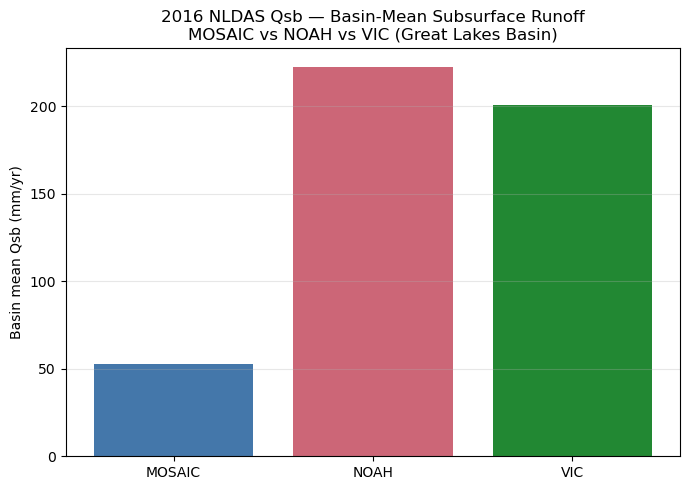

In [10]:
# ==== Basin Aggregated Comparison of Qsb (mm/yr) — MOSAIC, NOAH, VIC (2016) ====

from pathlib import Path
import numpy as np
import xarray as xr
import geopandas as gpd
from netCDF4 import Dataset
from shapely.geometry import Point
from shapely.prepared import prep
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------
# 1. Paths & constants
# -------------------------------------------------------
ROOTS = {
    "MOSAIC": Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2016"),
    "NOAH":   Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Noah\NLDAS\NLDAS_NOAH0125_M.2.0\2016"),
    "VIC":    Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\VIC\NLDAS\NLDAS_VIC0125_M.2.0\2016"),
}

VAR = "Qsb"  # subsurface runoff, monthly totals (kg/m^2 == mm/month)
GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"

# -------------------------------------------------------
# 2. Helper: find group containing VAR
# -------------------------------------------------------
def find_group(nc_path, var):
    def walk(g, path=""):
        if var in g.variables:
            return path
        for name, sub in g.groups.items():
            p = path + "/" + name if path else "/" + name
            out = walk(sub, p)
            if out:
                return out
        return None
    with Dataset(nc_path) as nc:
        if var in nc.variables:
            return ""
        return walk(nc)

# -------------------------------------------------------
# 3. Load GL boundary and build shapely mask (no rasterio)
# -------------------------------------------------------
glb = gpd.read_file(GL_BOUNDARY).to_crs(4326)
glb_poly = (glb.union_all() if hasattr(glb, "union_all") else glb.unary_union).buffer(0)
glb_prepared = prep(glb_poly)

# -------------------------------------------------------
# 4. Aggregation helper
# -------------------------------------------------------
def aggregate_stats(arr, weights):
    """
    arr: 2D array (lat x lon) in mm/yr, with NaNs outside grid/basin
    weights: 2D array same shape (area weights, e.g., cos(lat))
    """
    mask = np.isfinite(arr)
    if not np.any(mask):
        return {k: np.nan for k in ["area_mean", "simple_mean", "median", "p10", "p90"]}

    vals = arr[mask]
    w = weights[mask]

    stats = {
        "area_mean": np.average(vals, weights=w),
        "simple_mean": float(np.nanmean(vals)),
        "median": float(np.median(vals)),
        "p10": float(np.percentile(vals, 10)),
        "p90": float(np.percentile(vals, 90)),
    }
    return stats

# -------------------------------------------------------
# 5. Process each model
# -------------------------------------------------------
results = {}
lon_vals = None
lat_vals = None
basin_mask = None
weights_2d = None

for model, root in ROOTS.items():
    files = sorted(str(p) for p in root.rglob("*.nc*"))
    if not files:
        raise FileNotFoundError(f"No .nc/.nc4 files found under {root} for {model}")

    group_path = find_group(files[0], VAR)
    if group_path is None:
        raise KeyError(f"Variable '{VAR}' not found in {files[0]} for model {model}")
    print(f"[INFO] '{VAR}' found in group: {group_path or '/'} for {model}")

    ds = xr.open_mfdataset(
        files, group=(group_path or None),
        combine="by_coords", decode_times=True, parallel=False
    )
    if VAR not in ds:
        raise KeyError(f"{VAR!r} not in dataset for {model}. Available: {list(ds.data_vars)[:20]}")

    # Annual total (mm/yr) from monthly totals (kg/m^2 == mm/month)
    da = ds[VAR].sum("time", skipna=True)

    # Detect coord names
    lon_name = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
    lat_name = "lat" if "lat" in da.coords else ("latitude" if "latitude" in da.coords else None)
    if lon_name is None or lat_name is None:
        raise KeyError(f"Could not find lon/lat in coords for model {model}")

    # Normalize lon to [-180, 180], sort
    da = da.assign_coords({lon_name: xr.where(da[lon_name] > 180, da[lon_name] - 360, da[lon_name])})
    da = da.sortby(lon_name).sortby(lat_name)

    if lon_vals is None:
        # First model → define common grid
        lon_vals = da[lon_name].values
        lat_vals = da[lat_name].values

        # Build 2D lon/lat grid
        LON2D, LAT2D = np.meshgrid(lon_vals, lat_vals)

        # Build basin mask via shapely (no rasterio)
        flat_mask = []
        for x, y in zip(LON2D.ravel(), LAT2D.ravel()):
            flat_mask.append(glb_prepared.contains(Point(float(x), float(y))))
        basin_mask = np.array(flat_mask, dtype=bool).reshape(LAT2D.shape)

        # Area weights ~ cos(lat)
        weights_2d = np.cos(np.deg2rad(lat_vals))[:, None] * np.ones_like(LON2D)

    else:
        # Align other models to the first model's grid
        da = da.interp({lon_name: lon_vals, lat_name: lat_vals})

    # Extract as numpy, apply mask
    arr = da.values  # 2D (lat, lon)
    arr_masked = np.where(basin_mask, arr, np.nan)

    # Aggregate
    stats = aggregate_stats(arr_masked, weights_2d)
    results[model] = stats

# -------------------------------------------------------
# 6. Put results in a DataFrame and plot
# -------------------------------------------------------
df = pd.DataFrame(results).T[
    ["area_mean", "simple_mean", "median", "p10", "p90"]
]
print("\n===== Basin Aggregated Qs Comparison (mm/yr) — 2016, Great Lakes Basin =====\n")
print(df.round(2))

# Bar plot of area-weighted mean
plt.figure(figsize=(7, 5))
plt.bar(df.index, df["area_mean"], color=["#4477aa", "#cc6677", "#228833"])
plt.ylabel("Basin mean Qsb (mm/yr)")
plt.title("2016 NLDAS Qsb — Basin-Mean Subsurface Runoff\nMOSAIC vs NOAH vs VIC (Great Lakes Basin)")
plt.grid(axis="y", alpha=0.3)
plt.savefig(Figures / "nldas_qs_2016_glb_basin_mean_comparison.png", dpi=300)
plt.tight_layout()
plt.show()


## comparison of recharge/rainfall ration 


[INFO] 'Qsb' found in group: / for MOSAIC
[INFO] 'Qsb' found in group: / for NOAH
[INFO] 'Qsb' found in group: / for VIC


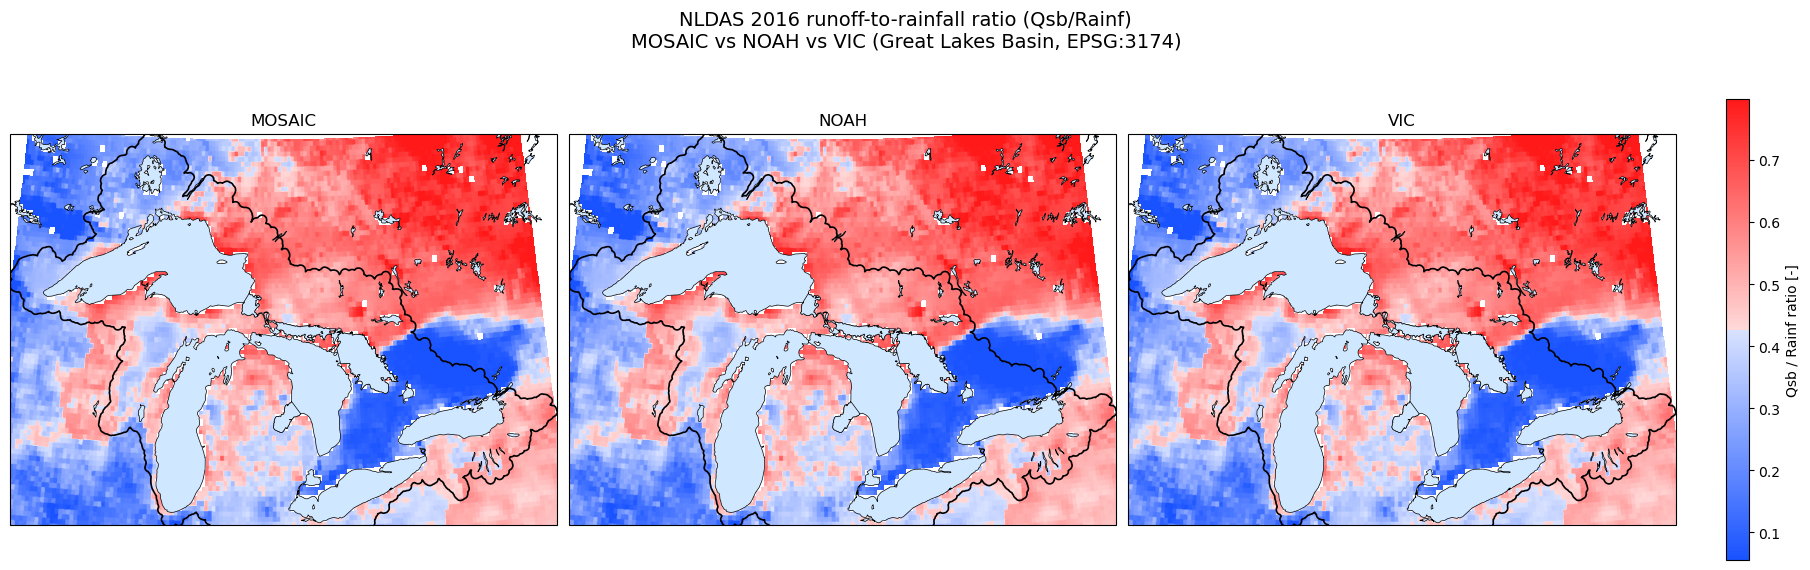

In [ ]:
# ==== NLDAS/Mosaic, NOAH, VIC Qs/Rainf — 2016 Annual Ratio,
#      clipped to GL boundary, smooth tripanel comparison in EPSG:3174 ====

from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from netCDF4 import Dataset
import cartopy.crs as ccrs
import colormaps as cmaps  # your custom colormaps module

# -------------------- Paths & constants --------------------
VAR_QSb   = "Qsb"     # subsurface runoff, monthly totals (kg/m^2 == mm/month)
VAR_RAIN = "Rainf"  # rainfall, monthly totals (kg/m^2 == mm/month)

MODEL_ROOTS = {
    "MOSAIC": Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Mosaic\NLDAS\NLDAS_MOS0125_M.2.0\2013"),
    "NOAH":   Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\Noah\NLDAS\NLDAS_NOAH0125_M.2.0\2013"),
    "VIC":    Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly\VIC\NLDAS\NLDAS_VIC0125_M.2.0\2013"),
}

GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"

CRS_LONLAT = 4326
CRS_PLOT   = 3174  # Great Lakes Albers

# -------------------- Helper: find group containing a variable --------------------
def find_group_with_var(nc_path: str, varname: str):
    """Return group path (e.g., '/grp/sub') or '' for root; None if not found."""
    def walk(grp, path=""):
        if varname in grp.variables:
            return path
        for name, sub in grp.groups.items():
            p = (path + "/" + name) if path else ("/" + name)
            found = walk(sub, p)
            if found is not None:
                return found
        return None
    with Dataset(nc_path) as nc:
        if varname in nc.variables:
            return ""  # root group
        return walk(nc, "")

# -------------------- Read GL boundary and lakes --------------------
glb_ll = gpd.read_file(GL_BOUNDARY).to_crs(CRS_LONLAT)
glb_poly = (glb_ll.union_all() if hasattr(glb_ll, "union_all") else glb_ll.unary_union).buffer(0)

lakes = gpd.read_file(LAKES_PATH)
lakes_proj = lakes.to_crs(CRS_PLOT)

glb_proj = glb_ll.to_crs(CRS_PLOT)
minx, miny, maxx, maxy = glb_proj.total_bounds
eps = 1e-6
if maxx <= minx:  # safety
    maxx = minx + eps
if maxy <= miny:
    maxy = miny + eps

# -------------------- Process models --------------------
masked_arrays = {}   # model_name -> 2D numpy array (lat x lon) of Qs/Rainf
lon_vals = None
lat_vals = None
lon_name = None
lat_name = None
mask_arr = None
used_bbox_only = False

for model_name, root in MODEL_ROOTS.items():
    files = sorted(str(p) for p in root.rglob("*.nc*"))
    if not files:
        raise FileNotFoundError(f"No .nc/.nc4 files found under {root} for {model_name}")

    # Find group using Qs (Rainf should be in same group)
    group_path = find_group_with_var(files[0], VAR_QSb)
    if group_path is None:
        raise KeyError(f"Variable '{VAR_QSb}' not found in {files[0]} for model {model_name}")
    print(f"[INFO] '{VAR_QSb}' found in group: {group_path or '/'} for {model_name}")

    open_kwargs = dict(
        combine="by_coords",
        chunks={"time": 12},
        parallel=False,
        decode_times=True,
        engine="netcdf4",
        backend_kwargs={"autoclose": True},
    )
    ds = xr.open_mfdataset(files, group=(group_path or None), **open_kwargs)

    if VAR_QSb not in ds or VAR_RAIN not in ds:
        raise KeyError(
            f"Required variables not in dataset for {model_name}. "
            f"Have: {list(ds.data_vars)[:20]}"
        )

    # Annual totals (mm/yr) from monthly totals (kg/m^2 == mm/month)
    da_qsb   = ds[VAR_QSb].sum("time", skipna=True)
    da_rain = ds[VAR_RAIN].sum("time", skipna=True)

    # ---- Coordinate setup (do once, then align others) ----
    if lon_name is None or lat_name is None:
        lon_name = "lon" if "lon" in da_qsb.coords else ("longitude" if "longitude" in da_qsb.coords else None)
        lat_name = "lat" if "lat" in da_qsb.coords else ("latitude" if "latitude" in da_qsb.coords else None)
        if not (lon_name and lat_name):
            raise KeyError("Couldn't find lon/lat coords.")

        # normalize lon to [-180,180] and sort for BOTH Qs and Rainf
        lon_fix = xr.where(da_qsb[lon_name] > 180, da_qsb[lon_name] - 360, da_qsb[lon_name])
        da_qsb   = da_qsb.assign_coords({lon_name: lon_fix})
        da_rain = da_rain.assign_coords({lon_name: lon_fix})

        if not np.all(np.diff(da_qs[lon_name].values) > 0):
            da_qs   = da_qs.sortby(lon_name)
            da_rain = da_rain.sortby(lon_name)
        if not np.all(np.diff(da_qs[lat_name].values) > 0):
            da_qs   = da_qs.sortby(lat_name)
            da_rain = da_rain.sortby(lat_name)

        lon_vals = da_qs[lon_name].values
        lat_vals = da_qs[lat_name].values

        # Build mask once (GL boundary)
        try:
            from rasterio.features import rasterize
            from affine import Affine
            dlon = float(lon_vals[1] - lon_vals[0])
            dlat = float(lat_vals[1] - lat_vals[0])
            transform_ll = (Affine.translation(float(lon_vals.min()) - dlon/2,
                                               float(lat_vals.min()) - dlat/2)
                            * Affine.scale(dlon, dlat))
            shapes = [(glb_poly.__geo_interface__, 1)]
            mask_arr = rasterize(
                shapes,
                out_shape=(lat_vals.size, lon_vals.size),
                transform=transform_ll,
                fill=0
            ).astype(bool)
        except Exception:
            # bbox fallback: just crop to GL bounds in lon/lat
            used_bbox_only = True
            xmin_glb, ymin_glb, xmax_glb, ymax_glb = glb_ll.total_bounds
            da_qsb   = da_qsb.sel({lon_name: slice(xmin_glb, xmax_glb),
                                 lat_name: slice(ymin_glb, ymax_glb)})
            da_rain = da_rain.sel({lon_name: slice(xmin_glb, xmax_glb),
                                   lat_name: slice(ymin_glb, ymax_glb)})
            lon_vals = da_qsb[lon_name].values
            lat_vals = da_qsb[lat_name].values
            mask_arr = np.ones((lat_vals.size, lon_vals.size), dtype=bool)

    else:
        # align this model to the reference lon/lat grid
        da_qsb = da_qsb.assign_coords({lon_name: xr.where(da_qsb[lon_name] > 180, da_qsb[lon_name] - 360, da_qsb[lon_name])})
        da_rain = da_rain.assign_coords({lon_name: xr.where(da_rain[lon_name] > 180, da_rain[lon_name] - 360, da_rain[lon_name])})

        da_qsb   = da_qsb.sortby(lon_name).sortby(lat_name)
        da_rain = da_rain.sortby(lon_name).sortby(lat_name)

        da_qsb   = da_qsb.interp({lon_name: lon_vals, lat_name: lat_vals})
        da_rain = da_rain.interp({lon_name: lon_vals, lat_name: lat_vals})

    # Compute ratio Qs / Rainf, avoid divide-by-near-zero
    rain_thresh = 1e-3  # mm/yr threshold; adjust as needed
    valid = da_rain > rain_thresh
    da_ratio = xr.where(valid, da_qs / da_rain, np.nan)
    da_ratio.attrs["units"] = "-"
    da_ratio.attrs["long_name"] = f"Qs / Rainf ratio ({model_name})"

    # Apply GL mask
    da_masked = da_ratio.where(
        xr.DataArray(mask_arr, dims=(lat_name, lon_name)),
        np.nan
    )

    # Store as (lat, lon) numpy array
    da_plot = da_masked.transpose(lat_name, lon_name)
    Z = np.asarray(da_plot)
    masked_arrays[model_name] = Z

# -------------------- Common extent & color limits --------------------
# lon/lat extent from reference grid
extent_lonlat = [float(lon_vals.min()), float(lon_vals.max()),
                 float(lat_vals.min()), float(lat_vals.max())]

# stack all models to compute shared color limits for ratio
stacked = np.dstack(list(masked_arrays.values()))
finite_all = np.isfinite(stacked)
if np.any(finite_all):
    vmin = np.nanpercentile(stacked[finite_all], 2)
    vmax = np.nanpercentile(stacked[finite_all], 98)
    # If you want to cap the ratio, e.g., 0–1.5, uncomment:
    # vmin, vmax = 0.0, 1.5
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
        vmin = vmax = None
else:
    vmin = vmax = None

# -------------------- Plot tripanel in EPSG:3174 --------------------
pc   = ccrs.PlateCarree()
proj = ccrs.epsg(CRS_PLOT)

fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 6),
    subplot_kw={"projection": proj},
    constrained_layout=True,
)

model_order = ["MOSAIC", "NOAH", "VIC"]
im = None

for ax, model_name in zip(axes, model_order):
    Z = masked_arrays[model_name]

    im = ax.imshow(
        Z,
        extent=extent_lonlat,
        transform=pc,
        origin="lower",
        interpolation="bilinear",
        cmap=cmaps.BlueRed,  # your YlGnBu colormap
        vmin=vmin, vmax=vmax,
        zorder=1,
    )

    # Lakes (light blue fill, black edge)
    lakes_proj.plot(
        ax=ax,
        facecolor="#cfe8ff",
        edgecolor="black",
        linewidth=0.5,
        zorder=2,
    )

    # GL boundary outline
    glb_proj.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=3)

    # Extent EXACTLY = GL boundary bounds in EPSG:3174
    ax.set_extent([minx, maxx, miny, maxy], crs=proj)

    ax.set_title(f"{model_name}")

# Shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85, pad=0.03)
cbar.set_label("Qsb / Rainf ratio [-]")

suptitle = "NLDAS 2016 runoff-to-rainfall ratio (Qsb/Rainf)\nMOSAIC vs NOAH vs VIC (Great Lakes Basin, EPSG:3174)"
if used_bbox_only:
    suptitle += ""
fig.suptitle(suptitle, fontsize=14)

# If you want to save:
# Figures = Path(r"your\figure\folder")
plt.savefig(Figures / "nldas_qs_rainf_ratio_2016_glb_tripanel.png", dpi=300)

plt.show()


# Compute average recharge for all three models

Estimating average recharge from 2000-2024 for all three model and save them as nc file 

In [1]:
from pathlib import Path
import xarray as xr
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

# --------- paths ---------
BASE = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly")

MODEL_ROOTS = {
    "MOSAIC": BASE / "Mosaic" / "NLDAS" / "NLDAS_MOS0125_M.2.0",
    "NOAH":   BASE / "Noah"   / "NLDAS" / "NLDAS_NOAH0125_M.2.0",
    "VIC":    BASE / "VIC"    / "NLDAS" / "NLDAS_VIC0125_M.2.0",
}

YEARS = range(2000, 2025)   # 2000–2024 inclusive


RECH_VAR = "Qsb"   # <- change to your recharge var name

## Compute average annual recharge 
This function calculates annual mean recharge for each year by averaging all valid monthly NLDAS files. It produces a time-series dataset showing how recharge varies across space and time.

In [2]:
from pathlib import Path
import xarray as xr

def annual_mean_recharge_for_model(
    model_root: Path,
    years=range(2000, 2024),
    var_name=RECH_VAR,
):
    """
    # annual_mean_recharge_for_model

    Compute **annual mean recharge** for a given NLDAS model over a range of years.

    ## Parameters
    - `model_root` (`Path`):
      Root directory for one model, with subfolders by year, e.g.:

      ```
      model_root / 2000 / *.nc
      model_root / 2001 / *.nc
      ...
      model_root / 2024 / *.nc
      ```

      Each year folder is expected to contain monthly NetCDF files.

    - `years` (iterable of int, default `range(2000, 2025)`):
      Sequence of years to process. For each year, the function looks for
      NetCDF files inside `model_root / f"{year}"`.

    - `var_name` (str):
      Name of the recharge variable in the NetCDF files (e.g. `"RECH"` or
      whatever is used in the NLDAS files).

    ## What it does

    For each year:
    1. Finds all NetCDF files in `model_root / year`.
    2. Tests each file by opening it with `xarray`:
       - If the file can be opened, it is considered **good**.
       - If opening fails (e.g., corrupted file), it is **skipped** and a message is printed.
    3. Opens all good monthly files for that year with `xr.open_mfdataset`.
    4. Takes the mean of `var_name` along the `"time"` dimension:
       - If each file is a monthly mean, then the mean over time gives the
         **annual mean recharge** for that year.
    5. Tags that 2D field (lat, lon) with the corresponding `year` coordinate
       and adds it to a list.

    After all years:
    - Concatenates all annual 2D fields along the `year` dimension to build a
      single DataArray with dimensions `(year, lat, lon)`.
    - Sorts by `year` to ensure chronological order.

    ## Returns

    - `da_all_years` (`xarray.DataArray`):

      A DataArray with dimensions:

      - `year` – integer calendar year (e.g. 2000–2024)
      - `lat`  – latitude
      - `lon`  – longitude

      Each slice `da_all_years.sel(year=YYYY)` is the **annual mean recharge**
      field for that year.

    ## Notes

    - Corrupted or unreadable monthly files are safely skipped and reported.
    - Years with no usable files are skipped with a warning.
    - If *no* annual data can be computed for any year, the function raises
      a `ValueError`.
    """
    annual_list = []
    seconds_per_year = 365.25 * 24 * 3600  # you can use 365.25 if you prefer

    for yr in years:
        year_dir = model_root / f"{yr}"
        all_files = sorted(year_dir.glob("*.nc*"))

        if not all_files:
            print(f"[WARN] No files for {model_root.name} in {yr}")
            continue

        good_files = []
        for f in all_files:
            try:
                with xr.open_dataset(f) as ds:
                    _ = list(ds.coords)
            except Exception as e:
                print(f"[SKIP] {model_root.name} {yr} -> {f.name}: {e}")
            else:
                good_files.append(f)

        if not good_files:
            print(f"[WARN] No usable files for {model_root.name} in {yr}")
            continue

        ds_year = xr.open_mfdataset(good_files, combine="by_coords")
        da = ds_year[var_name]
        units = (da.attrs.get("units") or "").lower()

        # ---- convert to mm/year ----
        if "s-1" in units or "/s" in units:        # rate, e.g. "kg m-2 s-1"
            # 1 kg/m² = 1 mm of water depth
            da_annual = da.mean("time") * seconds_per_year
            da_annual.attrs["units"] = "mm/year"
        else:
            # assume each time step is a depth (e.g. mm/month) and sum over months
            da_annual = da.sum("time")
            da_annual.attrs["units"] = "mm/year"

        # tag year and add a year dimension
        da_annual = da_annual.assign_coords(year=yr).expand_dims("year")
        annual_list.append(da_annual)

        ds_year.close()

    if not annual_list:
        raise ValueError(f"No annual data could be computed for {model_root}")

    da_all_years = xr.concat(annual_list, dim="year").sortby("year")
    return da_all_years


In [3]:
from pathlib import Path

BASE = Path(r"T:\Data\Climate_Data\Gridded\Downloaded\NLDAS_2_monthly")

MODEL_ROOTS = {
    "MOSAIC": BASE / "Mosaic" / "NLDAS" / "NLDAS_MOS0125_M.2.0",
    "NOAH":   BASE / "Noah"   / "NLDAS" / "NLDAS_NOAH0125_M.2.0",
    "VIC":    BASE / "VIC"    / "NLDAS" / "NLDAS_VIC0125_M.2.0",
}

annual_recharge = {}
for model, root in MODEL_ROOTS.items():
    print(f"\n=== {model} ===")
    annual_recharge[model] = annual_mean_recharge_for_model(root)


=== MOSAIC ===

=== NOAH ===
[SKIP] NLDAS_NOAH0125_M.2.0 2019 -> NLDAS_NOAH0125_M.A201908.020.nc: NetCDF: Can't open HDF5 attribute

=== VIC ===


In [5]:
OUTDIR = Path(r"D:\Users\abolmaal\modelling\Projects\GreatLakes\outputs")
# save the results
for model, da in annual_recharge.items():
    out_file = OUTDIR / f"{model}_annual_recharge_2000_2024.nc"
    print("Saving", out_file)
    da.to_netcdf(out_file)

Saving D:\Users\abolmaal\modelling\Projects\GreatLakes\outputs\MOSAIC_annual_recharge_2000_2024.nc
Saving D:\Users\abolmaal\modelling\Projects\GreatLakes\outputs\NOAH_annual_recharge_2000_2024.nc
Saving D:\Users\abolmaal\modelling\Projects\GreatLakes\outputs\VIC_annual_recharge_2000_2024.nc


### Read average recharge for three models 

In [8]:
RECH_VAR = "Qsb"   # <- change to your recharge var name
# read the results back 
loaded_recharge = {}
for model in MODEL_ROOTS.keys():
    in_file = OUTDIR / f"{model}_annual_recharge_2000_2024.nc"
    print("Loading", in_file)
    loaded_recharge[model] = xr.open_dataset(in_file)[RECH_VAR]


Loading D:\Users\abolmaal\modelling\Projects\GreatLakes\outputs\MOSAIC_annual_recharge_2000_2024.nc
Loading D:\Users\abolmaal\modelling\Projects\GreatLakes\outputs\NOAH_annual_recharge_2000_2024.nc
Loading D:\Users\abolmaal\modelling\Projects\GreatLakes\outputs\VIC_annual_recharge_2000_2024.nc


In [51]:
loaded_recharge["MOSAIC"]  # example access to MOSAIC annual recharge data

<xarray.DataArray 'Qsb' (year: 24, lat: 224, lon: 464)> Size: 10MB
array([[[0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [1.102006e-01, 1.123007e-01, ..., 1.427366e+02, 8.418403e+01],
        [1.295005e-01, 7.640029e-02, ..., 2.672041e+02, 1.100693e+02]],

       [[0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [9.360039e-02, 1.128004e-01, ..., 1.306534e+02, 7.498167e+01],
        [2.848015e-01, 1.135002e-01, ..., 2.449649e+02, 1.028111e+02]],

       ...,

       [[0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [8.660039e-02, 8.240040e-02, ..., 2.392828e+02, 1.876803e+02],
        [3.957899e+00, 7.280001e-01, ..., 3.912942e+02, 2.099074e+02]],

       [[0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [0.000000e+00, 0.000000e+00, ..., 2.396768e+02, 2.011811e+02],
        [9.011022e-01, 4.800005e-02, ..., 3.605505e+02, 2.134092e+02]]],
      shape=(24, 224, 464), dtype=float32)
Coordinates:
  * year     (year) int64 192B 2000 2001 2002 2003 2004 ... 2020 2021 2022 2023
  * lat      (lat) float32 896B 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * lon      (lon) float32 2kB -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
Attributes:
    units:    mm/year

In [9]:
clim_recharge = {m: da.mean("year") for m, da in loaded_recharge.items()}

In [20]:
import numpy as np

print("=== clim_3172 diagnostics ===")
for m, da in clim_recharge.items():
    arr = da.values
    print(
        m,
        "shape:", arr.shape,
        "finite count:", np.isfinite(arr).sum()
    )


=== clim_3172 diagnostics ===
MOSAIC shape: (224, 464) finite count: 103936
NOAH shape: (224, 464) finite count: 103936
VIC shape: (224, 464) finite count: 103936


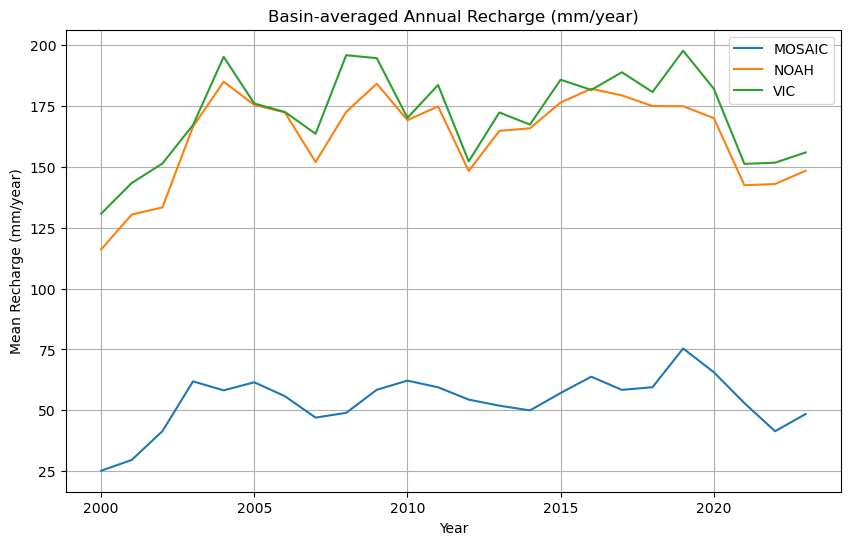

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for model, da in loaded_recharge.items():
    # convert kg/m2 to mm/year
    # da_mm = da * 1.0                     # explicit conversion
    # da_mm.attrs["units"] = "mm/year"

    # spatial mean over lat/lon
    basin_mean = da.mean(dim=["lat", "lon"])

    plt.plot(basin_mean["year"], basin_mean, label=model)

plt.xlabel("Year")
plt.ylabel("Mean Recharge (mm/year)")
plt.title("Basin-averaged Annual Recharge (mm/year)")
plt.legend()
plt.grid(True)
plt.savefig(Figures / "nldas_annual_recharge_timeseries_2000_2024.png", dpi=300)
plt.show()



In [45]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

from matplotlib.colors import ListedColormap, BoundaryNorm
import colormaps as cmaps  # <- your custom cmaps module

def plot_recharge_climatology_tripanel(
    clim_recharge,
    gl_boundary_path,
    lakes_path=None,
    models=("MOSAIC", "NOAH", "VIC"),
    levels=None,          # recharge class boundaries (mm/yr)
    cmap=None,            # default: cmaps.gnbu_8
    figsize=(11, 4),      # figure size in inches
    dpi=200,              # DPI for crisper output
):
    """
    Plot multi-model climatological recharge (mm/yr) over the Great Lakes basin
    in PlateCarree, with discrete color bins and cmaps.gnbu_8.

    Parameters
    ----------
    clim_recharge : dict
        {model_name: DataArray(lat, lon)} with mean recharge (mm/yr).

    gl_boundary_path : str/Path
        GL basin shapefile (must be in or convertible to EPSG:4326).

    lakes_path : str/Path, optional
        Lakes shapefile (optional overlay).

    models : tuple of str
        Model names to plot.

    levels : sequence of float, optional
        Recharge bin boundaries (mm/yr). If None, computed from percentiles.

    cmap : colormap or sequence of colors, optional
        Default is cmaps.gnbu_8.

    figsize : (float, float)
        Figure size in inches.

    dpi : int
        Figure DPI for resolution.
    """

    # ------------------ colormap ------------------
    if cmap is None:
        cmap = cmaps.gnbu_8  # your requested palette

    # If cmap is not already a matplotlib colormap, wrap it
    if not hasattr(cmap, "N"):
        cmap = ListedColormap(cmap)

    # ------------------ models available ------------------
    models_available = [m for m in models if m in clim_recharge]
    if not models_available:
        raise ValueError("None of the requested models are in clim_recharge.")
    if len(models_available) < len(models):
        missing = set(models) - set(models_available)
        print(f"[WARN] Missing models (skipped): {missing}")

    # ------------------ load & clean shapes ------------------
    glb = gpd.read_file(gl_boundary_path)
    if glb.crs is None:
        print("[WARN] GL basin shapefile has no CRS; assuming EPSG:4326.")
        glb = glb.set_crs("EPSG:4326")
    elif glb.crs.to_epsg() != 4326:
        glb = glb.to_crs("EPSG:4326")
    glb["geometry"] = glb.geometry.buffer(0)

    lakes = None
    if lakes_path is not None:
        lakes = gpd.read_file(lakes_path)
        if lakes.crs is None:
            print("[WARN] Lakes shapefile has no CRS; assuming EPSG:4326.")
            lakes = lakes.set_crs("EPSG:4326")
        elif lakes.crs.to_epsg() != 4326:
            lakes = lakes.to_crs("EPSG:4326")
        lakes["geometry"] = lakes.geometry.buffer(0)

    proj = ccrs.PlateCarree()

    # ------------------ compute levels if needed ------------------
    all_vals = []
    print("=== Model diagnostics (PlateCarree) ===")
    for m in models_available:
        da = clim_recharge[m]
        arr = da.values
        finite = np.isfinite(arr)
        if finite.any():
            print(
                f"  {m}: shape={arr.shape}, "
                f"min={arr[finite].min():.2f}, "
                f"max={arr[finite].max():.2f}, "
                f"finite_count={finite.sum()}"
            )
            all_vals.append(arr[finite])
        else:
            print(f"  {m}: shape={arr.shape}, all NaN")

    if not all_vals:
        raise ValueError("No finite data found in any model.")
    all_vals = np.concatenate(all_vals)

    if levels is None:
        # Example: 8 bins based on 5–95th percentiles
        q5 = np.nanpercentile(all_vals, 5)
        q95 = np.nanpercentile(all_vals, 95)
        # Round to nice numbers and build equal-width bins
        vmin = max(0.0, np.floor(q5 / 25) * 25)
        vmax = np.ceil(q95 / 25) * 25
        levels = np.linspace(vmin, vmax, 9)  # 8 bins → 9 boundaries
        print(f"Auto levels from 5–95th percentiles: {levels}")
    else:
        levels = np.asarray(levels, dtype=float)
        print(f"Using user-defined levels: {levels}")

    # Discrete norm
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    # ------------------ figure & axes ------------------
    fig, axes = plt.subplots(
        1, len(models_available),
        figsize=figsize,
        dpi=dpi,
        subplot_kw={"projection": proj},
        constrained_layout=True,
    )
    if len(models_available) == 1:
        axes = [axes]

    lon_min, lat_min, lon_max, lat_max = glb.total_bounds
    last_im = None

    # ------------------ plot each model ------------------
    for ax, m in zip(axes, models_available):
        da = clim_recharge[m]

        im = da.plot(
            ax=ax,
            transform=proj,
            cmap=cmap,
            norm=norm,
            add_colorbar=False,
        )
        last_im = im

        glb.boundary.plot(ax=ax, edgecolor="red", linewidth=0.8, transform=proj)
        if lakes is not None:
            lakes.boundary.plot(
                ax=ax,
                edgecolor="black",
                linewidth=0.5,
                transform=proj,
            )

        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
        ax.coastlines(resolution="50m", linewidth=0.5)
        ax.set_title(f"{m} mean recharge\n2000–2024 (mm/yr)", fontsize=11)

    # ------------------ colorbar with class boundaries ------------------
    cbar = fig.colorbar(
        last_im,
        ax=axes,
        shrink=0.7,
        pad=0.02,
        boundaries=levels,
        spacing="proportional",
    )
    cbar.set_label("Recharge (mm/year)", fontsize=14)
    cbar.set_ticks(levels)
    cbar.ax.tick_params(labelsize=9)
    plt.savefig(Figures / "nldas_recharge_climatology_tripanel.jpeg", dpi=dpi)
    plt.show()


=== Model diagnostics (PlateCarree) ===
  MOSAIC: shape=(224, 464), min=0.00, max=2559.08, finite_count=103936
  NOAH: shape=(224, 464), min=0.00, max=3276.12, finite_count=103936
  VIC: shape=(224, 464), min=-489.17, max=1863.75, finite_count=103936
Using user-defined levels: [  0.  50. 100. 150. 200. 250. 300. 400. 500.]


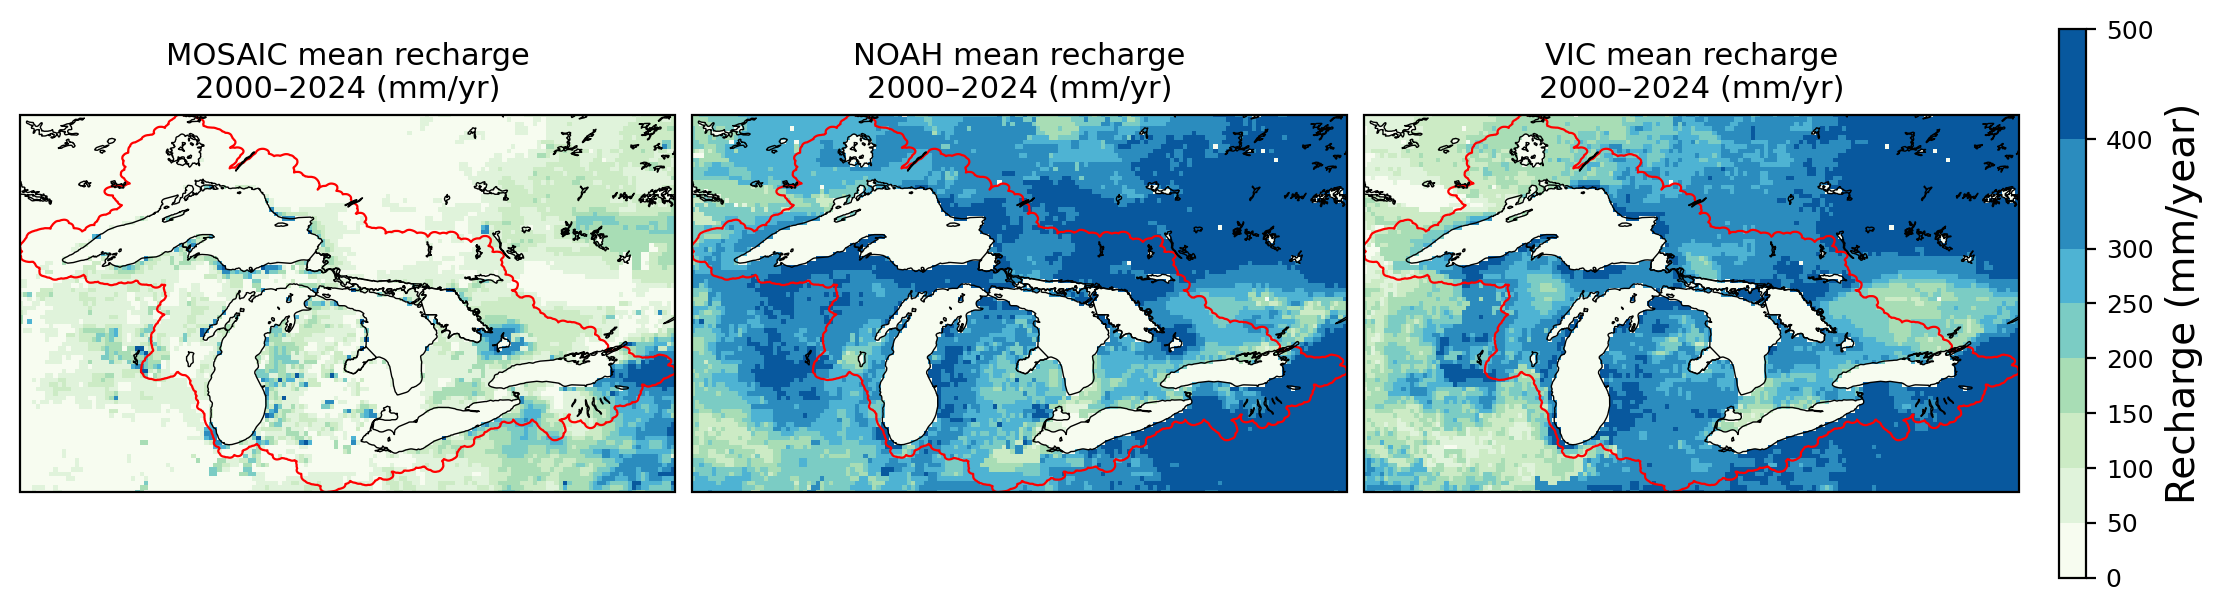

In [ ]:
GL_BOUNDARY = r"S:/Data/GIS_Data/Derived/Great_Lakes_Basin/Boundaries/buffered_glb_no_sls.shp"
LAKES_PATH  = r"S:/Data/GIS_Data/Downloaded/Worldwide_Datasets/Natural_Earth_Data/10m_physical/ne_10m_lakes.shp"
levels = [0, 50, 100, 150, 200, 250, 300, 400, 500]
plot_recharge_climatology_tripanel(
    clim_recharge=clim_recharge,
    gl_boundary_path=GL_BOUNDARY,
    lakes_path=LAKES_PATH,
    models=("MOSAIC", "NOAH", "VIC"),
    levels=levels,
    figsize=(11, 4),
    dpi=300,
)


## average recharge for each subbasin

In [49]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely import vectorized
subbasins = gpd.read_file(GL_SUBBASIN).to_crs("EPSG:4326")
print(subbasins.columns)

Index(['LAKEBASIN', 'COUNT', 'AREA', 'Dis', 'geometry'], dtype='object')


In [56]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely import contains_xy

lake_name_field = "LAKEBASIN"                         # <-- field with subbasin names

subbasins = gpd.read_file(GL_SUBBASIN).to_crs("EPSG:4326")

# Make sure CRS is EPSG:4326 (lat/lon) to match clim_recharge
if subbasins.crs is None:
    print("[WARN] Lake subbasin shapefile has no CRS; assuming EPSG:4326.")
    subbasins = subbasins.set_crs("EPSG:4326")
elif subbasins.crs.to_epsg() != 4326:
    subbasins = subbasins.to_crs("EPSG:4326")

# ------------------------------------
# 2. Build lon/lat grid from one model
# ------------------------------------
# Use any one DataArray from clim_recharge to get the grid
example_da = next(iter(clim_recharge.values()))
lat = example_da["lat"].values
lon = example_da["lon"].values
lon2d, lat2d = np.meshgrid(lon, lat)

results = []

# ------------------------------------
# 3. Loop over subbasins and models
# ------------------------------------
for _, row in subbasins.iterrows():
    basin_name = row[lake_name_field]
    geom = row.geometry

    # Boolean mask: which grid cells fall inside this subbasin polygon?
    mask = contains_xy(geom, lon2d, lat2d)  # shape (lat, lon)

    # Turn mask into a DataArray aligned with (lat, lon)
    mask_da = xr.DataArray(
        mask,
        coords={"lat": lat, "lon": lon},
        dims=("lat", "lon"),
    )

    for model, da in clim_recharge.items():
        # da is already in mm/year, so no unit conversion needed
        da_mm = da

        # Apply mask
        da_sub = da_mm.where(mask_da)

        # Mean recharge in this subbasin (mm/year), skipping NaNs
        mean_val = float(da_sub.mean().values)

        results.append(
            {
                "Model": model,
                "Subbasin": basin_name,
                "Recharge_mm_per_year": mean_val,
            }
        )

# ------------------------------------
# 4. Make a DataFrame
# ------------------------------------
df_recharge_subbasin = pd.DataFrame(results)
print(df_recharge_subbasin.head())


    Model Subbasin  Recharge_mm_per_year
0  MOSAIC     Erie             78.871597
1    NOAH     Erie            261.805817
2     VIC     Erie            325.848572
3  MOSAIC    Huron             89.366096
4    NOAH    Huron            349.355072


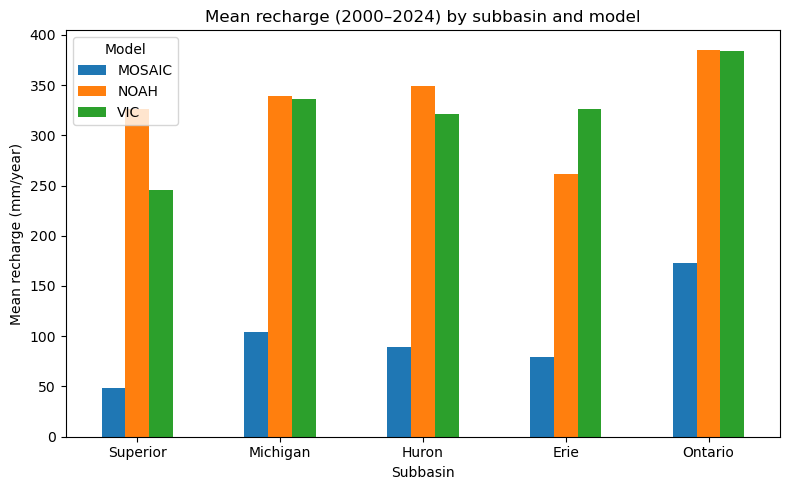

In [57]:
import matplotlib.pyplot as plt

# ensure consistent subbasin order
subbasin_order = ["Superior", "Michigan", "Huron", "Erie", "Ontario"]
df_recharge_subbasin["Subbasin"] = pd.Categorical(
    df_recharge_subbasin["Subbasin"],
    categories=subbasin_order,
    ordered=True,
)

pivot = df_recharge_subbasin.pivot(index="Subbasin", columns="Model", values="Recharge_mm_per_year")

fig, ax = plt.subplots(figsize=(8, 5))

pivot.plot(kind="bar", ax=ax)

ax.set_ylabel("Mean recharge (mm/year)")
ax.set_xlabel("Subbasin")
ax.set_title("Mean recharge (2000–2024) by subbasin and model")
ax.legend(title="Model")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(Figures / "nldas_meanrecharge_by_subbasin_2000_2024.jpeg", dpi=300)
plt.show()

### Compare the NLDAS model outputs with LHM deep percolation

In [59]:
LHM_recharge = Path (r"S:\Users\Samin\Brent_MI\v3-2000-2023\newBC_v3-2000-2023_deepPerc.nc")
# read the LHM recharge data
ds_lhm = xr.open_dataset(LHM_recharge)
ds_lhm

<xarray.Dataset> Size: 1GB
Dimensions:                        (Date: 288, Rows: 798, Cols: 647)
Coordinates:
  * Date                           (Date) datetime64[ns] 2kB 2000-01-31 ... 2...
  * Rows                           (Rows) int32 3kB 0 1 2 3 ... 794 795 796 797
  * Cols                           (Cols) int32 3kB 0 1 2 3 ... 643 644 645 646
Data variables:
    __xarray_dataarray_variable__  (Date, Rows, Cols) float64 1GB ...

In [34]:
# print the dataset to see variable names
print(ds_lhm.variables)

Frozen({'Date': <xarray.IndexVariable 'Date' (Date: 288)> Size: 2kB
array(['2000-01-31T00:00:00.000000000', '2000-02-29T00:00:00.000000000',
       '2000-03-31T00:00:00.000000000', ..., '2023-10-31T00:00:00.000000000',
       '2023-11-30T00:00:00.000000000', '2023-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]'), 'Rows': <xarray.IndexVariable 'Rows' (Rows: 798)> Size: 3kB
array([  0,   1,   2, ..., 795, 796, 797]), 'Cols': <xarray.IndexVariable 'Cols' (Cols: 647)> Size: 3kB
array([  0,   1,   2, ..., 644, 645, 646]), '__xarray_dataarray_variable__': <xarray.Variable (Date: 288, Rows: 798, Cols: 647)> Size: 1GB
[148696128 values with dtype=float64]})


In [60]:
from pathlib import Path
import numpy as np
import xarray as xr

# -----------------------------
# 1) Open the LHM recharge file
# -----------------------------

ds_lhm = xr.open_dataset(LHM_recharge)

print(ds_lhm)

# assume there is a single data variable like "__xarray_dataarray_variable__"
varname = list(ds_lhm.data_vars)[0]
da_m_per_month = ds_lhm[varname]              # (Date, Rows, Cols), units m/month

# Make sure the time coord is datetime (your screenshot says it is)
# If it weren't, you'd need: ds_lhm['Date'] = xr.decode_cf(ds_lhm).Date

# ------------------------------------------
# 2) Convert m/month → mm/month (×1000)
# ------------------------------------------
da_mm_month = da_m_per_month * 1000.0
da_mm_month.attrs.update(da_m_per_month.attrs)
da_mm_month.attrs["units"] = "mm/month"

# ------------------------------------------
# 3) Sum monthly depths into yearly mm/year
# ------------------------------------------
# Group by calendar year from the Date coordinate
da_mm_year = da_mm_month.groupby("Date.year").sum(dim="Date", skipna=True)
da_mm_year = da_mm_year.rename({"year": "Year"})
da_mm_year.attrs["units"] = "mm/year"
da_mm_year.name = "Recharge_mm_per_year"

# Result dimensions: (Year, Rows, Cols)
print(da_mm_year)

# ------------------------------------------
# 4) Save to a new NetCDF file
# ------------------------------------------
out_path = LHM_recharge.with_name("LHM_recharge_mm_per_year_2000_2023.nc")

ds_out = da_mm_year.to_dataset()
ds_out.attrs["source"] = (
    "Converted from m/month (LHM deepPerc) to mm/year by summing monthly depths "
    "for each calendar year."
)

ds_out.to_netcdf(out_path)
print("Saved annual recharge to:", out_path)




<xarray.Dataset> Size: 1GB
Dimensions:                        (Date: 288, Rows: 798, Cols: 647)
Coordinates:
  * Date                           (Date) datetime64[ns] 2kB 2000-01-31 ... 2...
  * Rows                           (Rows) int32 3kB 0 1 2 3 ... 794 795 796 797
  * Cols                           (Cols) int32 3kB 0 1 2 3 ... 643 644 645 646
Data variables:
    __xarray_dataarray_variable__  (Date, Rows, Cols) float64 1GB ...
<xarray.DataArray 'Recharge_mm_per_year' (Year: 24, Rows: 798, Cols: 647)> Size: 99MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., 

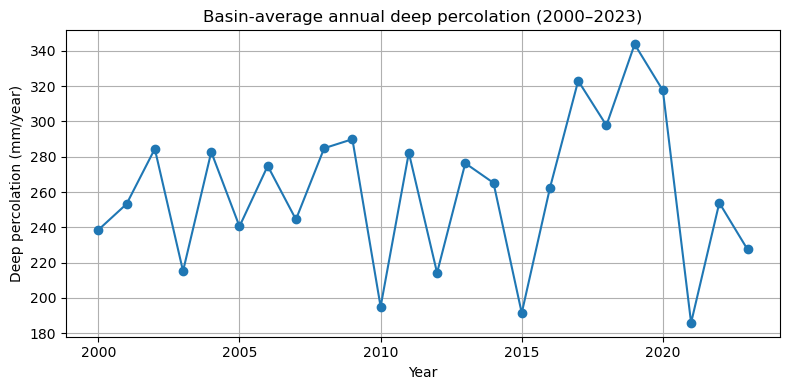

In [61]:
# 1) Basin-average monthly deep percolation (mm/month)
deep_mean_monthly = da_mm_month.mean(dim=("Rows", "Cols"))

# 2) Annual totals (mm/year) from monthly values
deep_annual = deep_mean_monthly.groupby("Date.year").sum()   # or .resample(Date="YE").sum()

# 3) Plot
fig, ax = plt.subplots(figsize=(8, 4))

deep_annual.plot(marker="o", ax=ax)
ax.set_xlabel("Year")
ax.set_ylabel("Deep percolation (mm/year)")
ax.set_title("Basin-average annual deep percolation (2000–2023)")
ax.grid(True)

plt.tight_layout()
plt.show()


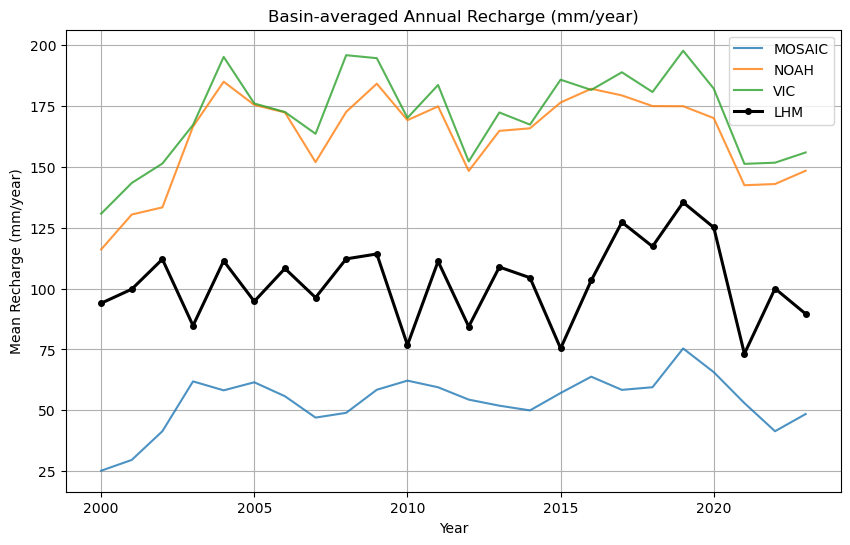

In [ ]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

# ---- your existing NLDAS part ----
plt.figure(figsize=(10, 6))

for model, da in loaded_recharge.items():
    # da: (year, lat, lon), already in mm/year
    basin_mean = da.mean(dim=["lat", "lon"])          # (year,)

    plt.plot(
        basin_mean["year"],
        basin_mean,
        label=model,
        alpha=0.8,
    )

# ---- add LHM annual recharge ----
LHM_ANN = Path(r"S:\Users\Samin\Data\Derived\Brent_MI\v3-2000-2023\LHM_recharge_mm_per_year_2000_2023.nc")
ds_lhm_ann = xr.open_dataset(LHM_ANN)

# adjust varname if different
da_lhm_ann = ds_lhm_ann["Recharge_mm_per_year"]      # (Year, Rows, Cols), mm/year

# basin-average
lhm_basin_mean = da_lhm_ann.mean(dim=("Rows", "Cols"))   # (Year,)

# rename coord to 'year' so it matches NLDAS style (optional but nice)
if "Year" in lhm_basin_mean.dims:
    lhm_basin_mean = lhm_basin_mean.rename({"Year": "year"})

# plot LHM as a thicker black line
plt.plot(
    lhm_basin_mean["year"],
    lhm_basin_mean,
    label="LHM",
    color="k",
    linewidth=2.2,
    marker="o",
    markersize=4,
)

# ---- formatting ----
plt.xlabel("Year")
plt.ylabel("Mean Recharge (mm/year)")
plt.title("Basin-averaged Annual Recharge (mm/year)")
plt.legend()
plt.grid(True)

plt.savefig(Figures / "nldas_lhm_annual_recharge_timeseries_2000_2024.png", dpi=300)
plt.show()


In [63]:
USGS_recharge = Path(r"S:\Users\Samin\Data\Derived\Sigler_Recharge\Recharge\glbRechargeFilled_m_d.shp")
usgs_rech_gdf = gpd.read_file(USGS_recharge).to_crs("EPSG:4326")
print(usgs_rech_gdf.columns)

Index(['AREAACRES', 'AREASQKM', 'STATES', 'HUC8', 'NAME', 'Shape_Leng',
       'Shape_Area', 'CODE', 'm_s', 'm_d', 'geometry'],
      dtype='object')


Text(0.5, 1.0, 'USGS-estimated Recharge (mm/year)')

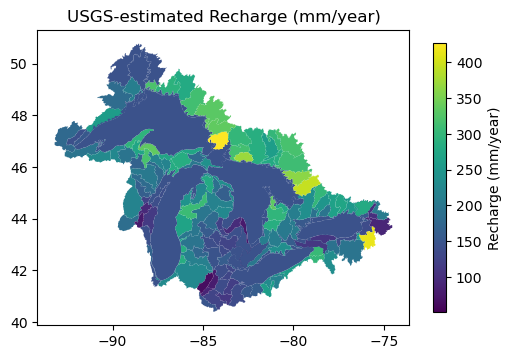

In [67]:
# plot the recharge shapefile
# convert m/day → mm/year
usgs_rech_gdf["rech_mm_yr"] = usgs_rech_gdf["m_d"] * 1000 * 365.25
ax = usgs_rech_gdf.plot(
    column="rech_mm_yr",
    cmap="viridis",
    legend=True,
    legend_kwds={"label": "Recharge (mm/year)", "shrink": 0.7},
    figsize=(6, 5),
)

ax.set_title("USGS-estimated Recharge (mm/year)")